In [1]:
import numpy as np
from scipy.linalg import block_diag
import scipy
import matplotlib.pyplot as plt
from adaptive_latents.transforms import proSVD
from adaptive_latents.transforms.jpca import align_column_spaces
from tqdm import tqdm

from functools import reduce

rng = np.random.default_rng()

In [2]:
def column_space_distance(Q1, Q2):
    Q1_rotated, Q2 = align_column_spaces(Q1, Q2)
    return np.linalg.norm(Q1_rotated - Q2)

In [34]:
def get_improvement_sample(n_samples=100, n1=4,n2=5,k=2):
    errors = [[],[]]
    for _ in range(n_samples):
        d = np.ones(n2)
        d[0] = 1.3
        d[-1] = 10
        d = np.diag(d)
        sub_d = d[:-(n2-n1),:-(n2-n1)] if n1 != n2 else d
        
        data = [
            sub_d @ rng.normal(size=(n1,n1)),
            sub_d @ rng.normal(size=(n1,5)),
            d @ rng.normal(size=(n2,n2)),
            d @ rng.normal(size=(n2,5)),
            ]
        
        
        psvd1 = proSVD(k)
        psvd2 = proSVD(k)
        
        psvd1.initialize(data[2])
        for i in np.arange(data[3].shape[1]):
            psvd1.updateSVD(data[3][:,i:i+1])
        
        psvd2.initialize(data[0])
        for i in np.arange(data[1].shape[1]):
                psvd2.updateSVD(data[1][:, i:i + 1])
            
        psvd2.add_new_input_channels(n2-n1)
        for j in [2,3]:
            for i in np.arange(data[j].shape[1]):
                psvd2.updateSVD(data[j][:, i:i + 1])
        
        ideal_basis = np.zeros((n2,2))
        ideal_basis[0,0] = 1
        ideal_basis[-1, 1] = 1
    
        errors[0].append(column_space_distance(psvd1.Q, ideal_basis))
        errors[1].append(column_space_distance(psvd2.Q, ideal_basis))
    errors = np.array(errors)
    diff = errors[0] - errors[1]
    return (errors[0] - errors[1] > 0).mean(), diff.mean()


stats = np.array([get_improvement_sample(50, n1=4, n2=10, k=2) for _ in tqdm(range(500))])

100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.46it/s]


1.0

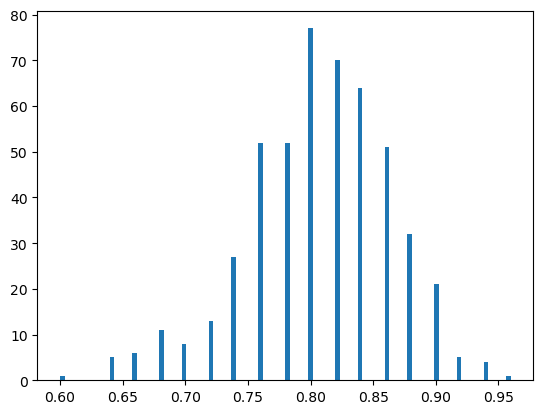

In [37]:
i = 0
plt.hist(stats[:,i],100);
(stats[:,i] > [.5, 0][i]).mean()

0.982

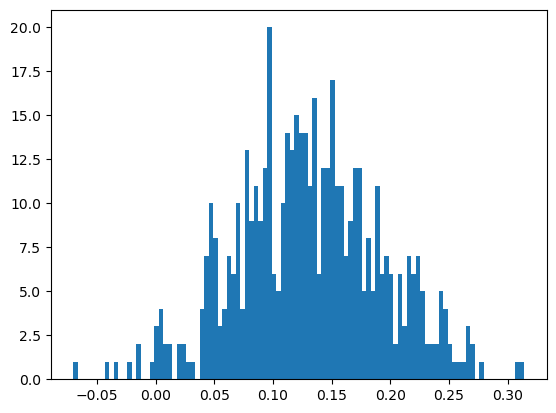

In [32]:
i = 1
plt.hist(stats[:,i],100);
(stats[:,i] > [.5, 0][i]).mean()

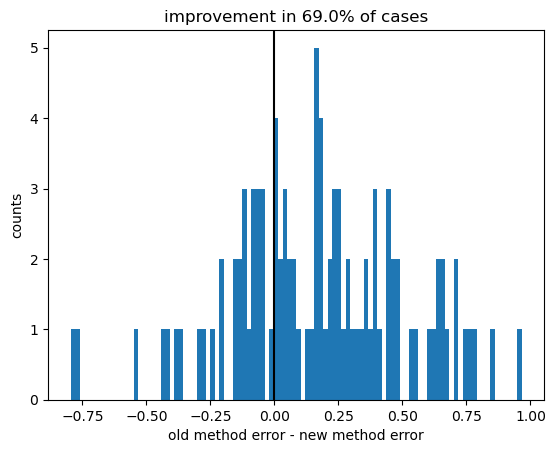

In [32]:
diffs = (method_errors[0] - method_errors[1])
fig, ax = plt.subplots()
ax.hist(diffs, 100);
ax.axvline(0,color='k')
ax.set_xlabel("old method error - new method error")
ax.set_ylabel("counts")
ax.set_title(f"improvement in {np.mean(diffs > 0)*100 :.1f}% of cases");

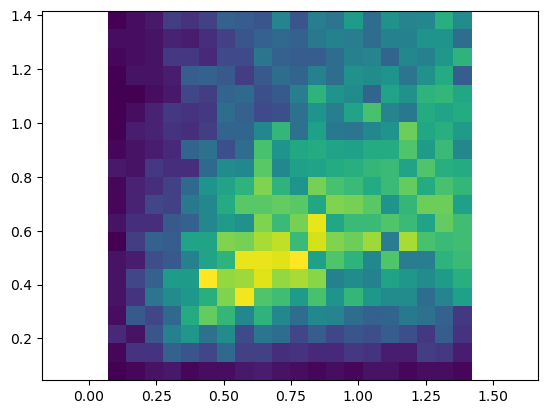

In [5]:
plt.hist2d(method_errors[0][:,1], method_errors[1][:,1], 20);
plt.axis('equal');

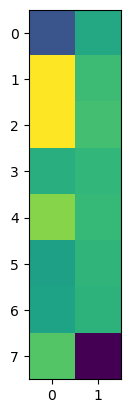

In [86]:
fig, axs = plt.subplots(ncols=1)
axs.imshow(psvd2.Q)

In [97]:
np.std(np.hstack(data[1:]),1)

array([1.14101744, 1.0044436 , 0.91037976, 0.92742566, 0.99154264,
       0.99672673, 0.97361922, 9.79926498])

In [98]:
np.std(np.hstack(data[0:1]),1)

array([1.38947511, 0.86283523, 0.82286691, 0.95512977, 1.02880607])

In [85]:
np.linalg.norm(Q2[:,0])

0.999999999999998